In [5]:
import os
import spacy
import networkx as nx
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import re

MiniRAG framework

In [88]:
nlp = spacy.load("en_core_web_sm")
embed_model = SentenceTransformer("all-MiniLM-L6-v2")  

class MiniRAGGraph:
    def __init__(self, similarity_threshold=0.8):
        self.graph = nx.Graph()
        self.entity_chunk_map = defaultdict(set)  # Track which entities belong to which chunk
        self.similarity_threshold = similarity_threshold
        self.entity_embeddings = {}  # Cache for entity embeddings
        
    def add_chunk(self, chunk_id, text):
        """Add text chunk as a node."""
        self.graph.add_node(chunk_id, type="chunk", text=text, embedding=embed_model.encode(text))
    
    def should_exclude_entity(self, entity_text):
        """Check if an entity should be excluded based on filtering rules."""
        entity_text = entity_text.strip()
        
        # Combined regex to check multiple conditions:
        # - Two-digit and three-digit numbers (e.g., 32, 123)
        # - Decimal numbers (e.g., 68.23)
        # - Numbers with a space in between (e.g., "98 4")
        # - Percentage patterns (e.g., 28%, 28.4%, 4.27%)
        # - Standalone percentage sign ("%")
        # - Number_x patterns (e.g., 28.4x, 5x)
        # - Numbers with dashes (e.g., 12-15, 12-15%)
        # - Page numbers (e.g., "Page 1", "page 12", "page")
        if re.fullmatch(r'(\d{2,3}|\d+\.\d+|\d+\s\d+|0?%|\d+\.?\d*%|\d+\.\d+%|\d+\.?\d*x|\d+-\d+%?|[Pp]age(\s\d+)?|\%)', entity_text):
            return True
            
        # Check for single-digit numbers (0-9)
        if entity_text.isdigit() and len(entity_text) == 1:
            return True

        return False
    
    def find_similar_entity(self, entity_text):
        """Find an existing entity that's similar to the given entity text."""
        if not self.entity_embeddings:  # If no entities yet
            return None
            
        entity_embedding = embed_model.encode(entity_text)
        
        # Get all entity embeddings
        existing_entities = list(self.entity_embeddings.keys())
        existing_embeddings = np.array(list(self.entity_embeddings.values()))
        
        # Calculate similarities
        similarities = cosine_similarity([entity_embedding], existing_embeddings)[0]
        
        # Find the most similar entity
        most_similar_idx = np.argmax(similarities)
        if similarities[most_similar_idx] >= self.similarity_threshold:
            return existing_entities[most_similar_idx]
        
        return None
    
    def add_entity(self, entity_text, chunk_id):
        """Add entity node and link it to the corresponding chunk."""
        # Check if entity should be excluded
        if self.should_exclude_entity(entity_text):
            return
            
        # Check if there's a similar entity already in the graph
        similar_entity = self.find_similar_entity(entity_text)
        
        if similar_entity:
            # Use the existing similar entity instead
            entity_to_use = similar_entity
        else:
            # Add new entity
            entity_to_use = entity_text
            if entity_text not in self.graph:
                embedding = embed_model.encode(entity_text)
                self.graph.add_node(entity_text, type="entity", embedding=embedding)
                self.entity_embeddings[entity_text] = embedding
        
        # Link entity to chunk
        self.graph.add_edge(entity_to_use, chunk_id, relation="mentions")
        self.entity_chunk_map[entity_to_use].add(chunk_id)
    
    def extract_entities(self, text, chunk_id):
        """Extract entities from text and add them to the graph."""
        doc = nlp(text)
        for ent in doc.ents:
            clean_entity = ent.text.replace("\n", " ")  # Replace newlines with spaces

            self.add_entity(ent.text, chunk_id)
    
    def add_entity_entity_edges(self):
        """Create edges between entities if they co-occur in the same chunk."""
        for chunk_id in self.graph.nodes:
            if self.graph.nodes[chunk_id].get("type") == "chunk":
                connected_entities = [n for n in self.graph.neighbors(chunk_id) if self.graph.nodes[n].get("type") == "entity"]
                for i in range(len(connected_entities)):
                    for j in range(i + 1, len(connected_entities)):
                        self.graph.add_edge(connected_entities[i], connected_entities[j], relation="co-occurs")

    def construct_graph(self, text_chunks):
        """Build the entire heterogeneous graph from text chunks."""
        for i, chunk in tqdm(enumerate(text_chunks)):
            chunk_id = i
            self.add_chunk(chunk_id, chunk)
            self.extract_entities(chunk, chunk_id)
        
        self.add_entity_entity_edges()

    def process_query(self, query):
        """Extract entities from a query and find relevant nodes in the graph."""
        doc = nlp(query)
        query_entities = {ent.text for ent in doc.ents if not self.should_exclude_entity(ent.text)}
        query_embedding = embed_model.encode(query)
        return query_entities, query_embedding
    
    def get_similar_entities(self, query_entity):
        """Find entities in the graph that are similar to the query entity."""
           
        query_embedding = embed_model.encode(query_entity)
        
        # Get all entity embeddings
        entities = list(self.entity_embeddings.keys())
        embeddings = np.array(list(self.entity_embeddings.values()))
        
        # Calculate similarities using cosine_similarity
        similarities = cosine_similarity([query_embedding], embeddings)[0]
        
        # Filter by threshold and create (entity, similarity) pairs
        similar_entities = [(entity, sim) for entity, sim in zip(entities, similarities) if sim >= self.similarity_threshold]
        
        return sorted(similar_entities, key=lambda x: x[1], reverse=True)

    def retrieve(self, query, top_k=5):
        query_entities, query_embedding = self.process_query(query)
    
        # Step 1: Identify relevant nodes including similar entities
        relevant_chunks = set()
        reasoning_paths = []
        
        for entity in query_entities:
            # Add direct matches
            if entity in self.graph:
                for chunk_id in self.entity_chunk_map[entity]:
                    relevant_chunks.add(chunk_id)
                    reasoning_paths.append((entity, chunk_id, 1.0))  # Full confidence for exact matches
            
            # Add similar entities
            similar_entities = self.get_similar_entities(entity)
            for similar_entity, similarity in similar_entities:
                for chunk_id in self.entity_chunk_map[similar_entity]:
                    relevant_chunks.add(chunk_id)
                    reasoning_paths.append((similar_entity, chunk_id, similarity))  # Weighted by similarity
        
        # Step 2: Rank chunks based on embedding similarity and graph structure
        ranked_chunks = []
        for chunk_id in relevant_chunks:
            chunk_embedding = self.graph.nodes[chunk_id]["embedding"]
            semantic_similarity = cosine_similarity([query_embedding], [chunk_embedding])[0][0]
            structural_score = sum(similarity for _, chunk, similarity in reasoning_paths if chunk == chunk_id)
            score = semantic_similarity + structural_score
            ranked_chunks.append((chunk_id, score))
        
        ranked_chunks.sort(key=lambda x: x[1], reverse=True)
        
        # Step 3: If retrieved chunks are less than top_k, add additional similar chunks
        if len(ranked_chunks) < top_k:
            all_chunks = [node for node in self.graph.nodes if self.graph.nodes[node].get("type") == "chunk"]
            additional_chunks = []
            
            for chunk_id in all_chunks:
                if chunk_id not in relevant_chunks:
                    chunk_embedding = self.graph.nodes[chunk_id]["embedding"]
                    similarity = cosine_similarity([query_embedding], [chunk_embedding])[0][0]
                    additional_chunks.append((chunk_id, similarity))
            
            additional_chunks.sort(key=lambda x: x[1], reverse=True)
            ranked_chunks.extend(additional_chunks[:top_k - len(ranked_chunks)])
        
        # Step 4: Return top k chunks with their scores and texts
        result = []
        for chunk_id, score in ranked_chunks[:top_k]:
            result.append({
                "chunk_id": chunk_id,
                "score": score,
                "text": self.graph.nodes[chunk_id]["text"],
                "paths": [p for p in reasoning_paths if p[1] == chunk_id]  # Include reasoning paths for explainability
            })
        
        return result
    
    def visualize_graph(self):
        """Visualize the graph with entities, chunks, and edges."""
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(14, 10))  # Increase figure size
        pos = nx.spring_layout(self.graph, seed=42, k=0.5)  # Adjust k for more spacing
        
        entity_nodes = [n for n in self.graph.nodes if self.graph.nodes[n].get("type") == "entity"]
        chunk_nodes = [n for n in self.graph.nodes if self.graph.nodes[n].get("type") == "chunk"]
        
        nx.draw(self.graph, pos, with_labels=True, node_color="lightgray", edge_color="gray", alpha=0.6, font_size=8)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=entity_nodes, node_color="skyblue", node_size=500)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=chunk_nodes, node_color="lightcoral", node_size=700)
        
        plt.title("MiniRAG Graph Visualization")
        plt.show()

    def llm(self, query, model="qwen2.5:3b", top_k=5):
        """Prompt a model in Ollama for response given the query and context retreived from MiniRAGGraph"""
        retrieved_chunks = self.retrieve(query, top_k=top_k)
        context = "\n\n\n".join([chunk["text"] for chunk in retrieved_chunks])
        
        prompt = f"""
        You are an AI assistant for an Endowment Fund, as context you receive quarterly letters provided by different managers held by the Endowment. Use the following retrieved context to answer the query accurately.
    
        Context:
        {context}
    
        Query:
        {query}
        """
    
        response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
        
        return response

In [3]:
def create_chunks(folder_path):
    # Get all PDF files in the folder
    pdf_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pdf")]
    
    # Initialize an empty list to store all text chunks
    all_text_chunks = []
    
    text_processor = RecursiveCharacterTextSplitter(
        chunk_size=2024,
        chunk_overlap=204,
        separators=["\n\n\n", "\n\n", "\n"],
        add_start_index=True
    )
    
    # Process each PDF file
    for file_path in tqdm(pdf_files):
        raw_docs = PDFPlumberLoader(file_path).load()
        chunks = text_processor.split_documents(raw_docs)
        text_chunks = [chunk.page_content for chunk in chunks]  
        all_text_chunks.extend(text_chunks)  
    
    print(f"Total number of chunks: {len(all_text_chunks)}")

    return all_text_chunks

# Chunk the data
folder_path = r"C:/Users/gabreu/Desktop/MyRAG/data"
chunks =  create_chunks(folder_path)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.14s/it]

Total number of chunks: 112


In [59]:
# create graphs
rag_graph = MiniRAGGraph(similarity_threshold=0.8)
rag_graph.construct_graph(chunks)

112it [00:42,  2.64it/s]


In [65]:
%%time
# Query
query = "Outline any discussion on Vistra from different managers"
for i in rag_graph.retrieve(query):
    print(i["chunk_id"])

39
40
41
37
6
CPU times: total: 203 ms
Wall time: 62.6 ms


In [62]:
query =  "Did anyone leave Third Point?"
for i in rag_graph.retrieve(query):
    print(i["chunk_id"])

111
107
110
85
100


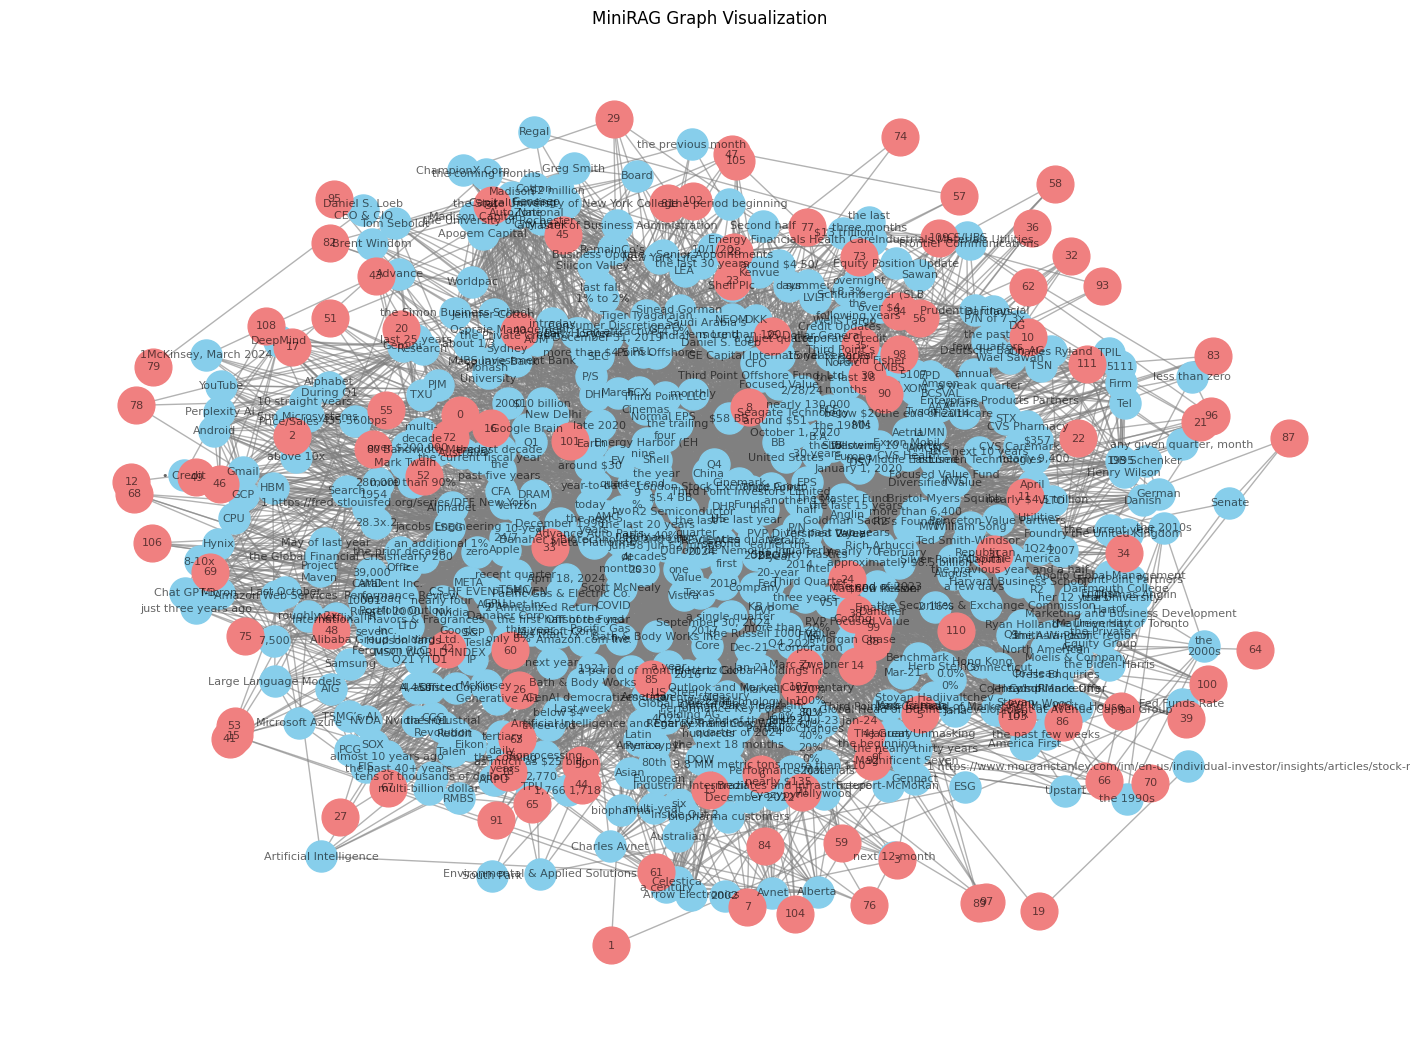

In [60]:
rag_graph.visualize_graph()

In [74]:
%%time
query =  "What new team members joined Third Point in 2023?"
response = rag_graph.llm(query, model="qwen2.5:3b", top_k=5)
print(response['message']['content'])

In 2023, the following new team members joined Third Point:

1. **Marc Zwebner** - He returned to Third Point as Co-Head of Marketing.
   
2. **Stoyan Hadjivaltchev** - He rejoined Third Point and was identified in the Corporate Credit Update section for being a new member.

Marc Zwebner's role is significant, particularly given his history with insurance companies and private credits funds, which could have implications for their structured credit portfolio.

Stoyan Hadjivaltchev's role in corporate credit appears to be related to investments in mortgage securities, which suggests he may be involved in the residential mortgage exposure mentioned in the Portfolio Updates section.
CPU times: total: 1.3 s
Wall time: 2min 53s


In [75]:
%%time
query =  "What new team members joined Third Point in 2023?"
response = rag_graph.llm(query, model="qwen2.5:3b", top_k=3)
print(response['message']['content'])

In 2023, two new team members joined Third Point:

1. Marc Zwebner: He returned to Third Point as Co-Head of Marketing. Previously, he was the Global Head of Business Development at Avenue Capital Group.

2. Stoyan Hadjivaltchev: He rejoined Third Point and will have a senior role across the equities portfolio, helping with idea generation, research, portfolio construction, and talent development. His previous experience includes being on the equities team from 2006-2008 and returning as a Managing Director from 2012 to 2020.

These are the new additions mentioned in the provided context for 2023.
CPU times: total: 859 ms
Wall time: 1min 46s


In [92]:
%%time
query =  "What new team members joined Third Point in 2023?"
response = rag_graph.llm(query, model="qwen2.5:3b", top_k=2)
print(response['message']['content'])

In 2023, Marc Zwebner rejoined Third Point as Co-Head of Marketing. Additionally, Stoyan Hadjivaltchev also rejoined the firm from 2012 to 2020 and will have a senior role across the equities portfolio.

No new team members joined Third Point in 2023 based on the provided context.
CPU times: total: 797 ms
Wall time: 1min 3s


In [94]:
rag_graph.retrieve("What new team members joined Third Point in 2023?", top_k=2)

[{'chunk_id': 107,
  'score': 3.4300665259361267,
  'text': '15 February 2024\nThird Point Q4 2023 Investor Letter\nThird Point LLC, the Investment Manager of Third Point Investors Limited (“TPIL” or the “Company”)\nannounces it has published its quarterly investor letter for Q4 2023. The full letter can be accessed at\nthe Company’s website: https://www.thirdpointlimited.com/resources/portfolio-updates.\nHighlights:\n• The Master Fund generated a 7.6% gain in the Fourth Quarter, with contributions from\nequity longs, risk arbitrage, and corporate credit offset modestly by equity shorts and\nhedges.\n• Most of the major detractors during the first and second quarters rebounded in the second\nhalf of the year, which, along with successful risk arbitrage positions in Activision Blizzard\nand US Steel, resulted in equity returns above the benchmark indices for the period.\n• The Investment Manager sees a constructive backdrop for both equities and credit in 2024,\nas it continues to find 

The rate is 34 seconds per 2024 character chunk